In [1]:
import math
import json
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def calc_frequencies(cov, gene, window):
    #Find percent polymorphism at each site
    #Also determine whether polymorphism is silent or replacement
    input_file_outgroup = '../'+str(cov)+'/auspice/seasonal_corona_'+str(cov)+'_'+str(gene)+'_root-sequence.json'
    input_file_alignment = '../'+str(cov)+'/results/aligned_'+str(cov)+'_'+str(gene)+'.fasta'
    metafile = '../'+str(cov)+'/results/metadata_'+str(cov)+'_'+str(gene)+'.tsv'

    #Subset data based on time windows
    meta = pd.read_csv(metafile, sep = '\t')
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    date_range = meta['year'].max() - meta['year'].min()
    
    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            #sliding window
            date_window_end += 1
            date_window_start += 1     

    #initiate lists to record all time windows
    year_windows = []
    seqs_in_window = []
    polymorphic_frequencies = []
    replacement_frequencies = []
    silent_frequencies = []
    
    for years, subset_viruses in virus_time_subset.items():
        if len(subset_viruses) != 0:
            year_windows.append(years)
            seqs_in_window.append(len(subset_viruses))
            
            outgroup_seq = ''
            outgroup_aa_seq = ''
            with open(input_file_outgroup, "r") as outgroup_handle:
                outgroup = json.load(outgroup_handle)
                outgroup_seq = SeqRecord(Seq(outgroup['nuc']))
                outgroup_aa_seq = outgroup_seq.translate()

            count_polymorphic = np.zeros(len(outgroup_seq))
            count_total_unambiguous = np.zeros(len(outgroup_seq))
            count_replacement_mutations = np.zeros(len(outgroup_seq))
            count_silent_mutations = np.zeros(len(outgroup_seq))

            with open(input_file_alignment, "r") as aligned_handle:
                for virus in SeqIO.parse(aligned_handle, "fasta"):
                    #Only viruses in time window
                    if virus.id in subset_viruses:
                        #check
                        if len(virus.seq) != len(outgroup_seq):
                            print(virus)
                        elif len(virus.seq) == len(outgroup_seq):
                            for pos in range(len(outgroup_seq)):
                                outgroup_nt = str(outgroup_seq[pos])
                                virus_nt = str(virus.seq[pos])
                                #skip ambiguous sites
                                if virus_nt != 'N':
                                    count_total_unambiguous[pos]+=1
                                    if virus_nt != outgroup_nt:
                                        count_polymorphic[pos]+=1
                                        #determine silent or replacement
                                        codon = math.floor(pos/3)
                                        codon_pos = pos-(codon*3)
                                        if codon_pos == 0:
                                            codon_nt = virus.seq[pos:(pos+3)]
                                        elif codon_pos == 1:
                                            codon_nt = virus.seq[(pos-1):(pos+2)]
                                        elif codon_pos == 2:
                                            codon_nt = virus.seq[(pos-2):(pos+1)]
                                        codon_aa = codon_nt.translate()
                                        outgroup_aa = outgroup_aa_seq[codon]
                                        if codon_aa != outgroup_aa:
                                            count_replacement_mutations[pos]+=1
                                        elif codon_aa == outgroup_aa:
                                            count_silent_mutations[pos]+=1



            polymorphic_frequencies_window = count_polymorphic/count_total_unambiguous
            replacement_frequencies_window = count_replacement_mutations/count_polymorphic
            silent_frequencies_window = count_silent_mutations/count_polymorphic
            
            polymorphic_frequencies.append(polymorphic_frequencies_window)
            replacement_frequencies.append(replacement_frequencies_window)
            silent_frequencies.append(silent_frequencies_window)
            
    return year_windows, seqs_in_window, polymorphic_frequencies, replacement_frequencies, silent_frequencies

In [3]:
def bhatt_variables(cov, gene, window):
    (year_windows,seqs_in_window, polymorphic_frequencies, replacement_frequencies, silent_frequencies) = calc_frequencies(cov, gene, window)
    
    #Initiate lists to store a values
    window_midpoint = []
    adaptive_substitutions = []
    
    
    #Categorize sites into fixation, low freq, medium freq and high freq polymorphisms (and silent or replacement)
    for years_window in range(len(polymorphic_frequencies)):
        #don't use windows with fewer than 3 sequences
        if seqs_in_window[years_window] >= 3:
            window_start = int(year_windows[years_window][0:4])
            window_end = int(year_windows[years_window][-4:])
            window_midpoint.append((window_start + window_end)/2)

            sf = 0
            rf = 0
            sh = 0
            rh = 0
            sm = 0
            rm = 0
            sl = 0
            rl = 0

            window_polymorphic_freqs = polymorphic_frequencies[years_window]
            for site in range(len(window_polymorphic_freqs)):
                pfreq = window_polymorphic_freqs[site]
                #ignore sites with no polymorphisms?
                if pfreq!= 0:
                    if pfreq == 1:
                        sf+= (pfreq*silent_frequencies[years_window][site])
                        rf+= (pfreq*replacement_frequencies[years_window][site])
                    elif pfreq > 0.75:
                        sh+= (pfreq*silent_frequencies[years_window][site])
                        rh+= (pfreq*replacement_frequencies[years_window][site])
                    elif pfreq > 0.15 and pfreq < 0.75:
                        sm+= (pfreq*silent_frequencies[years_window][site])
                        rm+= (pfreq*replacement_frequencies[years_window][site])
                    elif pfreq < 0.15:
                        sl+= (pfreq*silent_frequencies[years_window][site])
                        rl+= (pfreq*replacement_frequencies[years_window][site])       
                        
#             print(year_windows[years_window])
#             print(sf, rf, sh, rh, sm, rm, sl, rl)  

            #Calculate equation 1: number of nonneutral sites
            al = rl - sl*(rm/sm)
            ah = rh - sh*(rm/sm)
            af = rf - sf*(rm/sm)
            #set negative a values to zero
            if al < 0:
                al = 0
            if ah < 0:
                ah = 0
            if af < 0:
                af = 0

#             print(al, ah, af)

            #Calculate the number and proportion of all fixed or high-freq sites that have undergone adaptive change
            number_adaptive_substitutions = af + ah
            adaptive_substitutions.append(number_adaptive_substitutions)
            proportion_adaptive_sites = (af + ah)/(rf +rh)
            
    # get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(window_midpoint, adaptive_substitutions)
    
    ax = sns.regplot(x= window_midpoint, y=adaptive_substitutions, 
                     line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.ylabel('number of adaptive substitutions')
    plt.xlabel('year')
    
    ax.legend()
    plt.show()
        

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide


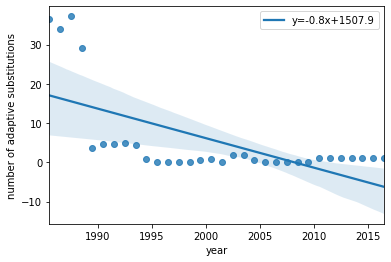

In [4]:
bhatt_variables('oc43', 'spike', 5)

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide


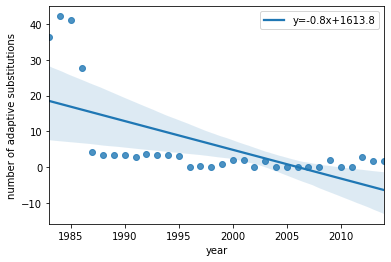

In [6]:
bhatt_variables('oc43', 'spike', 10)

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in double_scalars


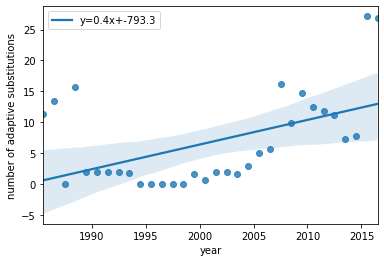

In [22]:
#old data
bhatt_variables('oc43', 'spike', 5)

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in double_scalars


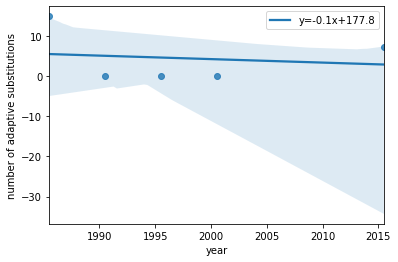

In [18]:
#old data
bhatt_variables('oc43', 'replicase1ab', 5)

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide


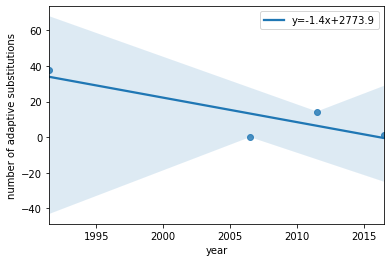

In [18]:
#old data
bhatt_variables('229e', 'spike', 5)

In [ ]:
#Bhatt method to calculate rate of adaptation

def calc_frequencies_old(cov, gene):
    
    #Find percent polymorphism at each site
    #Also determine whether polymorphism is silent or replacement
    input_file_outgroup = '../../config/'+str(cov)+'_'+str(gene)+'_reference.gb'
    input_file_alignment = '../../results/aligned_'+str(cov)+'_'+str(gene)+'.fasta'
    outgroup_seq = ''
    outgroup_aa_seq = ''
    with open(input_file_outgroup, "r") as outgroup_handle:
        for outgroup in SeqIO.parse(outgroup_handle, "genbank"):
            outgroup_seq = outgroup.seq
            outgroup_aa_seq = outgroup.seq.translate()

    count_polymorphic = np.zeros(len(outgroup.seq))
    count_total_unambiguous = np.zeros(len(outgroup.seq))
    count_replacement_mutations = np.zeros(len(outgroup.seq))
    count_silent_mutations = np.zeros(len(outgroup.seq))

    with open(input_file_alignment, "r") as aligned_handle:
        for virus in SeqIO.parse(aligned_handle, "fasta"):
            #check
            if len(virus.seq) != len(outgroup_seq):
                print(virus)
            elif len(virus.seq) == len(outgroup_seq):
                for pos in range(len(outgroup_seq)):
                    outgroup_nt = str(outgroup_seq[pos])
                    virus_nt = str(virus.seq[pos])
                    #skip ambiguous sites
                    if virus_nt != 'N':
                        count_total_unambiguous[pos]+=1
                        if virus_nt != outgroup_nt:
                            count_polymorphic[pos]+=1
                            #determine silent or replacement
                            codon = math.floor(pos/3)
                            codon_pos = pos-(codon*3)
                            if codon_pos == 0:
                                codon_nt = virus.seq[pos:(pos+3)]
                            elif codon_pos == 1:
                                codon_nt = virus.seq[(pos-1):(pos+2)]
                            elif codon_pos == 2:
                                codon_nt = virus.seq[(pos-2):(pos+1)]
                            codon_aa = codon_nt.translate()
                            outgroup_aa = outgroup_aa_seq[codon]
                            if codon_aa != outgroup_aa:
                                count_replacement_mutations[pos]+=1
                            elif codon_aa == outgroup_aa:
                                count_silent_mutations[pos]+=1



    polymorphic_frequencies = count_polymorphic/count_total_unambiguous
    replacement_frequencies = count_replacement_mutations/count_polymorphic
    silent_frequencies = count_silent_mutations/count_polymorphic
    return polymorphic_frequencies, replacement_frequencies, silent_frequencies

In [ ]:
def calc_bhatt_variables_old(cov, gene):
    (polymorphic_frequencies, replacement_frequencies, silent_frequencies) = calc_frequencies(cov, gene)
    #Categorize sites into fixation, low freq, medium freq and high freq polymorphisms (and silent or replacement)

    sf = 0
    rf = 0
    sh = 0
    rh = 0
    sm = 0
    rm = 0
    sl = 0
    rl = 0

    for site in range(len(polymorphic_frequencies)):
        pfreq = polymorphic_frequencies[site]
        #ignore sites with no polymorphisms?
        if pfreq!= 0:
            if pfreq == 1:
                sf+= (pfreq*silent_frequencies[site])
                rf+= (pfreq*replacement_frequencies[site])
            elif pfreq > 0.75:
                sh+= (pfreq*silent_frequencies[site])
                rh+= (pfreq*replacement_frequencies[site])
            elif pfreq > 0.15 and pfreq < 0.75:
                sm+= (pfreq*silent_frequencies[site])
                rm+= (pfreq*replacement_frequencies[site])
            elif pfreq < 0.15:
                sl+= (pfreq*silent_frequencies[site])
                rl+= (pfreq*replacement_frequencies[site])            

#     print(sf, rf, sh, rh, sm, rm, sl, rl)  

    #Calculate equation 1: number of nonneutral sites
    al = rl - sl*(rm/sm)
    ah = rh - sh*(rm/sm)
    af = rf - sf*(rm/sm)
    
    print(al, ah, af)

    #Calculate the proportion of all fixed or high-freq sites that have undergone adaptive change
    proportion_adaptive_sites = (af + ah)/(rf +rh)
#     print(adaptive_sites)

In [ ]:
calc_bhatt_variables_old('hku1', 'spike')